In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train.csv', index_col='PassengerId')
df_test = pd.read_csv('data/test.csv', index_col='PassengerId')

<h1>EDA<h1>

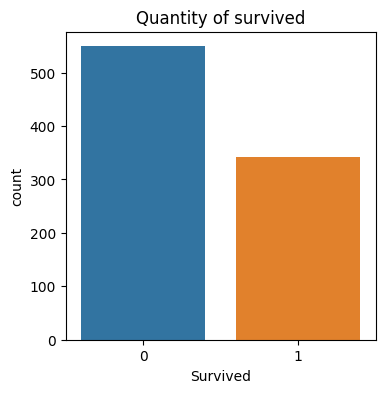

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.countplot(x='Survived', data=df_train)
plt.title('Quantity of survived')
plt.show()

In [14]:
not_surv = len(df_train[df_train['Survived']==0])
surv = len(df_train[df_train['Survived']==1])
print(round(surv*100/df_train.shape[0]), 
      '% of passanger survived in train dataset')
print(round(not_surv*100/df_train.shape[0]), 
      '% of passanger not survived in train dataset')

38 % of passanger survived in train dataset
62 % of passanger not survived in train dataset


In [15]:
#Checking dtypes of features
df_train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [20]:
numeric = ['Age', 'SibSp', 'Parch', 'Fare']

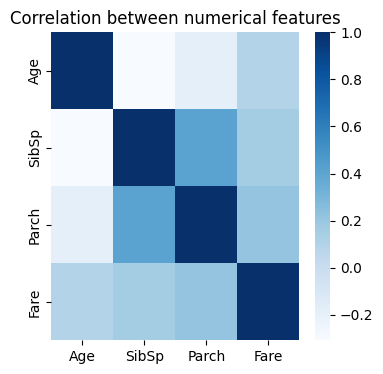

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(df_train[numeric].corr(method='pearson'),
            cmap="Blues").set(title='Correlation between numerical features');


In [36]:
categorical = ['Pclass', 'Sex', 'Embarked']

In [37]:
from scipy.stats import chi2_contingency

In [46]:
def check_chi2(dataframe, target, features):
    for feature in features:
        chi2 = chi2_contingency(pd.crosstab(dataframe[target], dataframe[feature]))
        print(f'P-value for %s: %s'%(feature, chi2[1]))

In [47]:
check_chi2(df_train, 'Survived', categorical)

P-value for Pclass: 4.549251711298793e-23
P-value for Sex: 1.1973570627755645e-58
P-value for Embarked: 1.769922284120912e-06


<h2>Features impact<h2>

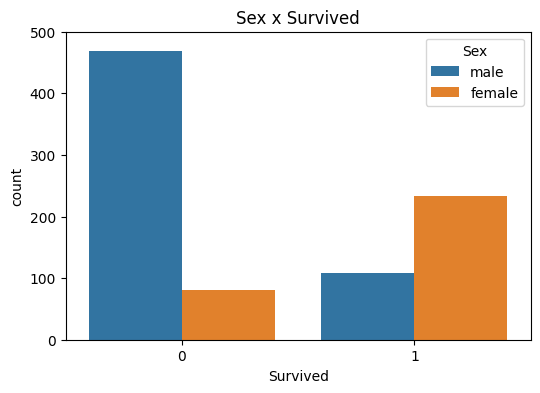

In [56]:
#Female passengers have higher chances to survive
fig, ax=plt.subplots(figsize=(6, 4))
sns.countplot(x='Survived', data=df_train, hue='Sex')
ax.set_ylim(0,500)
plt.title('Sex x Survived')
plt.show()

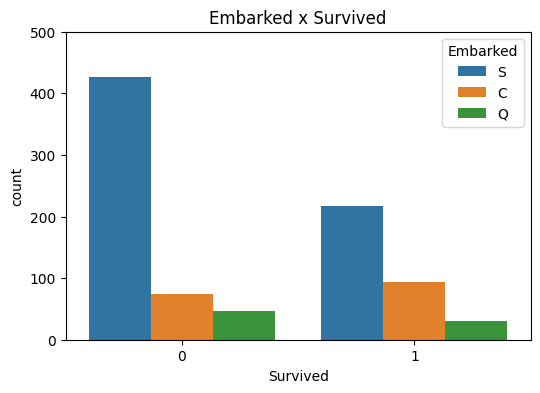

In [55]:
#Passengers from C have higher chances to survive
fig, ax=plt.subplots(figsize=(6, 4))
sns.countplot(x='Survived', data=df_train, hue='Embarked')
ax.set_ylim(0,500)
plt.title("Embarked x Survived")
plt.show()

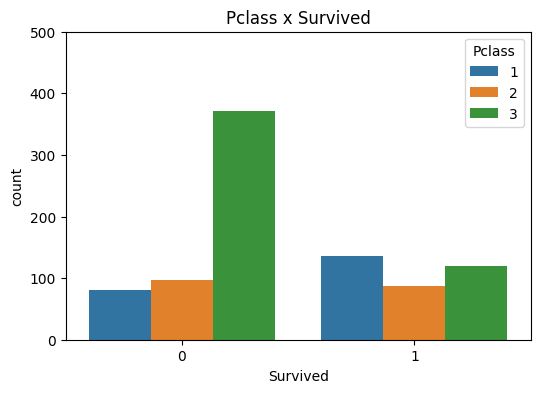

In [54]:
#Passengers from 1st class have higher chances to survive
fig, ax=plt.subplots(figsize=(6, 4))
sns.countplot(x='Survived', data=df_train, hue='Pclass')
ax.set_ylim(0,500)
plt.title("Pclass x Survived")
plt.show()

In [76]:
#Mean fare of survived passengers is higher than mean fare of dead passengers
print(round(np.mean(df_train['Fare'][df_train['Survived']==0]), 2), 'is mean fare for passengers who not survived')
print(round(np.mean(df_train['Fare'][df_train['Survived']==1]), 2), 'is mean fare for passengers who survived')

22.12 is mean fare for passengers who not survived
48.4 is mean fare for passengers who survived


<h2>Filling NaN values<h2>

<h3>Age<h3>

In [120]:
#Four features have missing values. Most of them are age and cabin features.
pd.DataFrame([df_train.drop(['Survived'], axis=1).isnull().sum(), 
              df_test.isnull().sum()])

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0


In [103]:
#Filling missing age values with median from train dataframe
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_train['Age'].median())

<h3>Cabin<h3>

In [111]:
df_train['Cabin'].value_counts()

0              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

In [110]:
df_train['Cabin'] = df_train['Cabin'].fillna(0)
df_test['Cabin'] = df_test['Cabin'].fillna(0)

<h3>Embarked and fare<h3>

In [113]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [114]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

In [119]:
df_test['Fare'] = df_test['Fare'].fillna(df_train['Fare'].median())

<h3>Feature engineering<h3>

In [124]:
#New feature if passenger has cabin or not
df_train['HasCabin'] = np.where(df_train['Cabin']==0, 0, 1)
df_test['HasCabin'] = np.where(df_test['Cabin']==0, 0, 1)

In [126]:
#New feature showing total number of family members
['Family'] = df_train.apply(lambda x: x['SibSp'] + x['Parch'], axis=1)
df_test['Family'] = df_test.apply(lambda x: x['SibSp'] + x['Parch'], axis=1)

In [131]:
#Changing data types of categorical features
categorical = ['Pclass', 'Sex', 'Embarked', 'HasCabin']
for col in categorical:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [135]:
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Family
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S,0,0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,0
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,0,S,0,3


In [138]:
#Dropping reduntant features and creating train target array
y = df_train['Survived']
X_train = df_train.drop(['Name', 'Survived', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)
X_test = df_test.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1)

In [140]:
#Creating dummy features
X_train = pd.get_dummies(X_train, columns=categorical, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical, drop_first=True)

KeyError: "None of [Index(['Pclass', 'Sex', 'Embarked', 'HasCabin'], dtype='object')] are in the [columns]"

<h1>Model<h1>

In [143]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y, test_size=0.3, random_state=17)

In [144]:
rf_clf = RandomForestClassifier(random_state=17)

In [145]:
parameters =  { 
    'n_estimators': [50, 500, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
}

In [147]:
%time
cv_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=parameters, cv=5)
cv_rf_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


/Users/macbook/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/macbook/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/macbook/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this p

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 500, 500]})

In [148]:
cv_rf_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 50}

In [149]:
best_rf_clf = RandomForestClassifier(random_state=17,
                                     max_features='auto',
                                     max_depth=7,
                                     n_estimators=50,
                                     criterion='entropy')

In [150]:
best_rf_clf.fit(X_train, y_train)

/Users/macbook/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(criterion='entropy', max_depth=7, max_features='auto',
                       n_estimators=50, random_state=17)

In [151]:
prediction = best_rf_clf.predict(X_holdout)

In [153]:
accuracy_score(y_holdout, prediction)

0.7985074626865671

In [155]:
test_prediction = best_rf_clf.predict(X_test)

In [160]:
titatic_subm = pd.DataFrame([np.array(np.arange(892, 1310)), test_prediction]).T \
    .rename(columns={0:'PassengerId', 1:'Survived'})
titatic_subm.to_csv('titanic_subm.csv', index=False)